In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.animation as animation

from IPython.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

**Future Todo**

1. Mathematical Quantity to explain the divergence behaviour between revenue and sales / transaction during holiday season
2. Why there are peaks and troughs in revenue/sales/transactions per day plot
3. Mean being representation of data points and how standard deviation comes into play
4. Understand How can we compare between two groups with different samples size. This is one of the
   [video](https://youtu.be/OyB_w4XNQ58?feature=shared) i came across will seeing if welch's t test is good for
   comparing transaction number between November and December
5. Fully understand all the conclusion and why things in *November and December comparision* under second question

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### CEO report 

#### First Question: How the business is doing? Is it great or bad?

Showing increase in revenue, transactions and atv

##### Seeing graphs

To answer this, i will show revenue per month first which includes returns thus CEO would understand
how much money the company is making per month and what is trend of this making money per month. There is
also trend of revenue per day.

<img src="monthly_revenue.png" alt="Monthly Revenue" width="600"/>

Here we can see that after the drop the revenue is increasing steadily even though it is holiday season (cuz gift shop)
the end is higher than 2010-12 revenue. Thus marking growth in business. Here 2011-12 is lower due to dataset recording sales
for 9 days which is 2011-12-01 to 2011-12-09

But if we look at daily revenue, the last day marked the highest recorded revenue

<img src="daily_revenue.png" alt="Daily Revenue" width="600"/>

Again if we want to look at growth, let's look at daily total transaction (total unique invoices). Here it total
transaction is increased from values from troughs.

<img src="daily_trx.png" alt="Daily Transactions" width="600"/>

Lastly let's look at combined transactions, sales (total quantity) and revenue per day polynomial plot.

<img src="comparison.png" alt="Comparison" width="600"/>

Here towards the end, the revenue has more slope than sales, thus saying that customer are buying pricier products.
This can be shown in ATV (Average Transaction Value) which is increasing.

<img src="monthly_atv.png" alt="Monthly ATV" width="600"/>

Showing that average revenue per transaction is increasing.

##### Total revenue generated

In [5]:
# total revenue including business expense and returns

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
print('${:,.2f}'.format(df["TotalPrice"].sum()))

$9,747,747.93


##### Per Day Trend

In [46]:
# real sales per day

# with returns and without business things only product being sold or returned
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

summary = real_sales.groupby(df['InvoiceDate'].dt.date).agg(
    TotalTransactions=('InvoiceNo', 'nunique'),  # Count transactions
    TotalSales=('Quantity', 'sum'),          # Sum quantity sold
    TotalRevenue=('TotalPrice', 'sum')       # Sum total revenue
).reset_index()

summary['Days'] = summary['InvoiceDate'].apply(lambda x: x.toordinal())

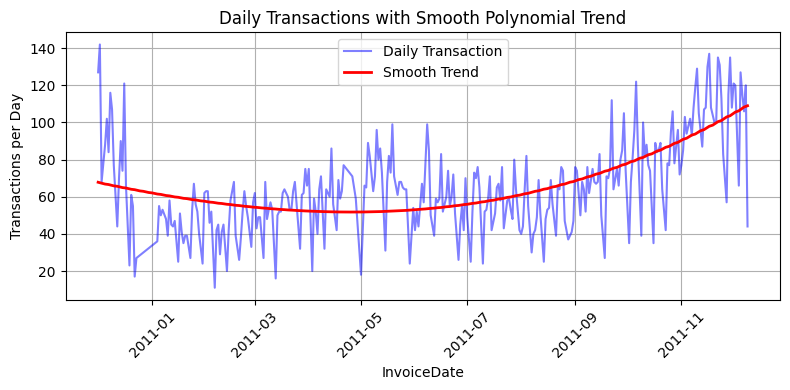

In [52]:
# plotting transaction per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
trx_coef = np.polyfit(summary['Days'], summary['TotalTransactions'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_trx = np.polyval(trx_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalTransactions'], label='Daily Transaction', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_trx, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Transactions per Day")
plt.title("Daily Transactions with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_trx.png")
plt.show()

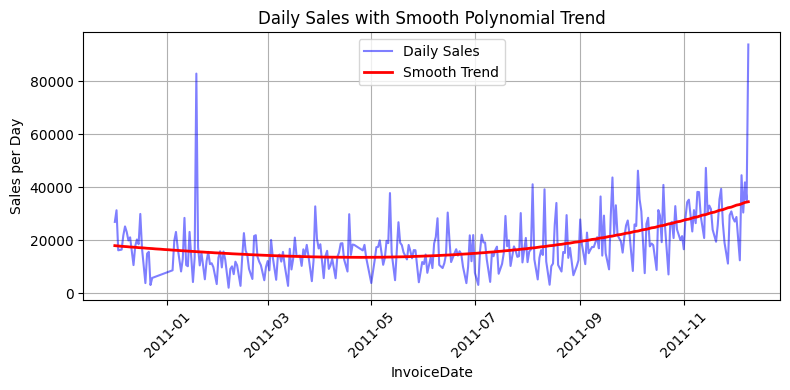

In [48]:
# plotting sales per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
sales_coef = np.polyfit(summary['Days'], summary['TotalSales'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_sales = np.polyval(sales_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalSales'], label='Daily Sales', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_sales, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Sales per Day")
plt.title("Daily Sales with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

**Note**: Above sales plot doesn't make sense as sales is total sales or quantity we sold not the returns we
are accounting. I will let it be, and leaving this note here for future me. But the revenue below and transaction
makes sense as we have to adjust number of returns and total money we have to return back to customer

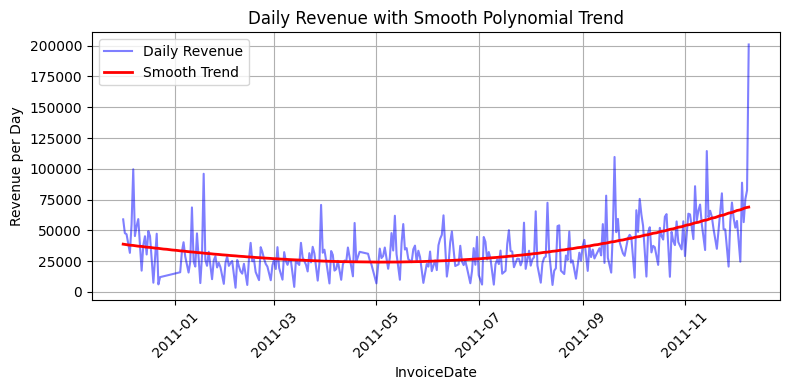

In [50]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
revenue_coef = np.polyfit(summary['Days'], summary['TotalRevenue'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_revenue = np.polyval(revenue_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
"""
temp = np.linspace(summary['TotalRevenue'].min(), summary["TotalRevenue"].max(), 15)
xtemp = [pd.to_datetime("2011-06-14")] * 15
plt.plot(xtemp, temp, color="green")  # date when returns are highest. i.e., total quantity < 0
"""
plt.plot(summary['InvoiceDate'], summary['TotalRevenue'], label='Daily Revenue', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Day")
plt.title("Daily Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_revenue.png")
plt.show()

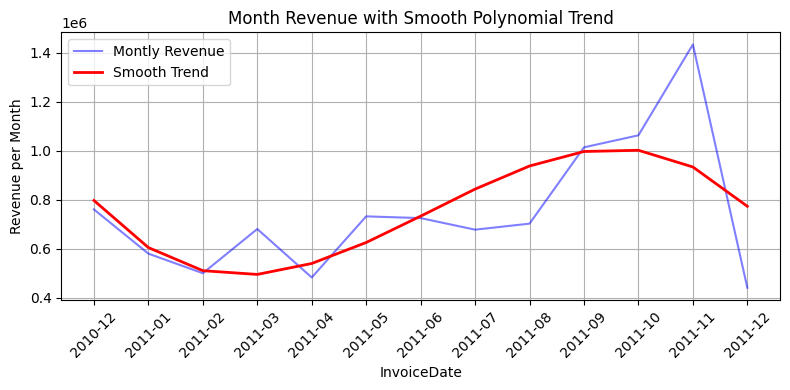

In [44]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

monthlyrev = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M'))["TotalPrice"].sum().reset_index()
monthlyrev["months"] = np.arange(monthlyrev["InvoiceDate"].size)

degree = 3
revenue_coef = np.polyfit(monthlyrev['months'], monthlyrev['TotalPrice'], degree)
smooth_revenue = np.polyval(revenue_coef, monthlyrev["months"])

plt.plot(monthlyrev['InvoiceDate'].apply(str), monthlyrev['TotalPrice'], label='Montly Revenue', color='blue', alpha=0.5)
plt.plot(monthlyrev['InvoiceDate'].apply(str), smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Month")
plt.title("Month Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("monthly_revenue.png")
plt.show()

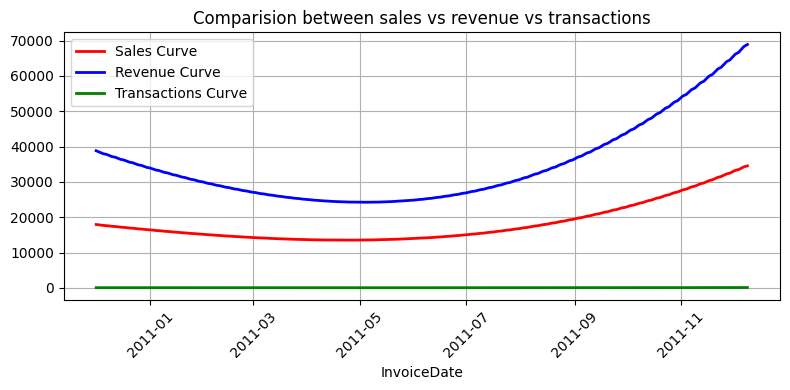

In [51]:
# comparing polynomial curvess

plt.figure(figsize=(8, 4))

plt.plot(smooth_dates, smooth_sales, label='Sales Curve', color='red', linewidth=2)
plt.plot(smooth_dates, smooth_revenue, label='Revenue Curve', color='blue', linewidth=2)
plt.plot(smooth_dates, smooth_trx, label='Transactions Curve', color='green', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.title("Comparision between sales vs revenue vs transactions")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

**Overal trend of curves**

- If the sales curve (blue) and revenue curve (red) follow a similar pattern (e.g., both increase or decrease at the same time), it suggests that sales and revenue are strongly correlated. This is common in retail, where higher sales directly lead to higher revenue.

- If the curves diverge significantly, it could indicate that revenue is not directly proportional to sales. This might happen due to:
  - Discounts or promotions: Higher sales volume but lower revenue due to reduced prices.
  - High-value items: Fewer sales but higher revenue due to expensive products.

But this is real_sales subset, so curves won't diverge. As said above about correlation.

**Peaks and Troughs**

- Peaks: If both curves peak at the same time, it indicates seasonal trends or successful marketing campaigns that boosted both sales and revenue.

- Troughs: If both curves dip simultaneously, it could indicate low-demand periods (e.g., holidays, off-seasons) or operational issues (e.g., stockouts).

Looking at above curve, during holiday season both sides are at peak indicating high transaction, sales and thus revenue. It lowers during the off season like summer one.

Also after `2011-07`, all the curves pick up but the revenue one has more slope or incline than other two. Indicating more
pricey stuff is being bought. To understand look at the delta r (revenue) and s (sales) for small time period. Here r > s, if s 
= 1 then r is like 2 or something. Which means having sold one product at price of 2x it's number. which is this overall product
is being priced at 2 something.

Same can be said for sales quantity and number of transaction.

**Divergent Behaviour**

*Future Todo*: Have a mathematical quantity which defines the above divergence when holiday season is coming

**Why those peaks and troughs**

*Future Todo*: Investigate what caused these peaks/troughs (e.g., promotions, holidays, stock issues).

In [76]:
# day when returns are more than sales

summary[summary["TotalSales"] == summary["TotalSales"].min()]

,InvoiceDate,TotalTransactions,TotalSales,TotalRevenue,Days
152,2011-06-14,1581,-13657,39953.82,734302


##### ATV (Average Transaction Value)

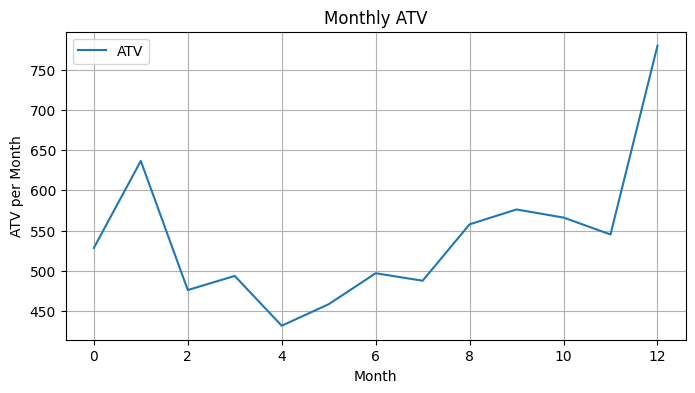

In [89]:
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
atv_data = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M')).apply(
    lambda x: x["TotalPrice"].sum() / x["InvoiceNo"].nunique()
).reset_index(name="ATV")
atv_data.plot(kind='line', figsize=(8, 4))
plt.title('Monthly ATV')
plt.xlabel('Month')
plt.ylabel('ATV per Month')
plt.grid(True)
plt.show()

#### Second Question: How is our business growing over time?

##### Growth Rate

In [7]:
# taking returns into account

real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy(deep=True)

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

'\nreal_sales = df[~(df["UnitPrice"] < 0)]\nstock_series = real_sales["StockCode"]\nstock_series = stock_series.astype(str)\nreal_sales = real_sales[stock_series.str.contains(r\'\\d\', na=False)]\n'

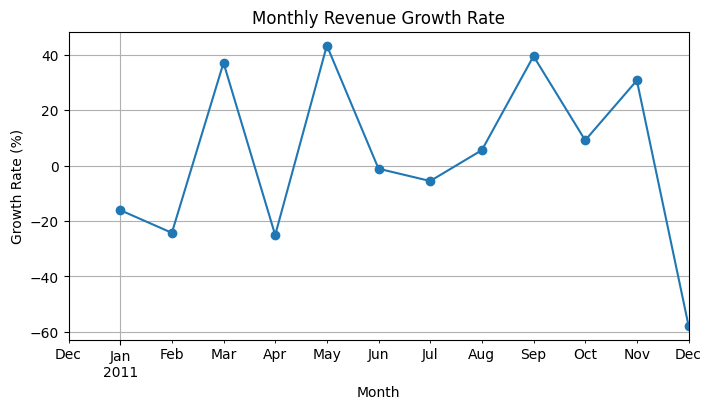

In [100]:
monthly_revenue = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
revenue_growth_rate = monthly_revenue.pct_change() * 100

# Plot revenue growth rate
revenue_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Revenue Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

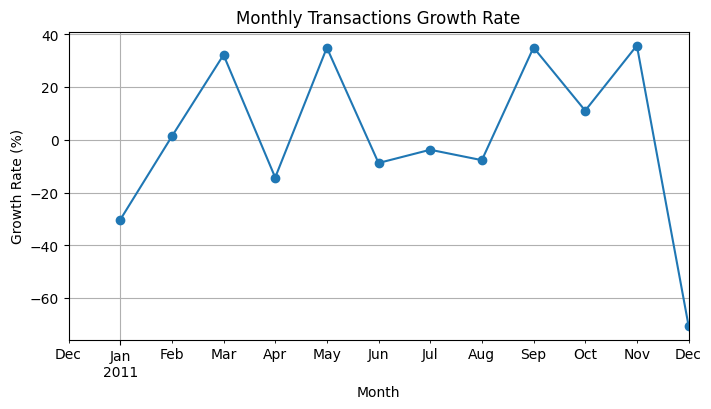

In [93]:
monthly_transactions = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].nunique()
transaction_growth_rate = monthly_transactions.pct_change() * 100

transaction_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Transactions Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

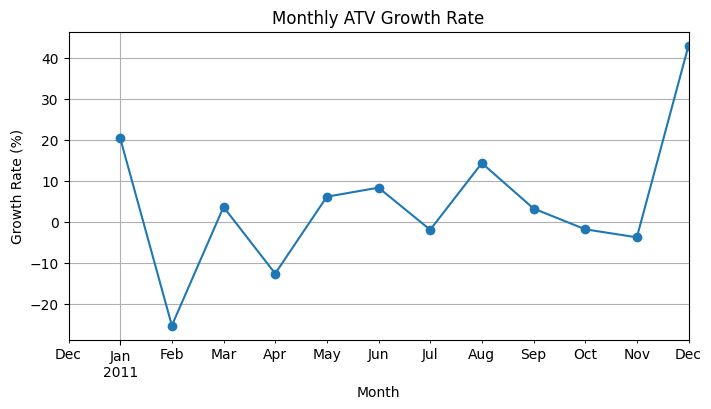

In [98]:
monthly_atv = real_sales.groupby(df['InvoiceDate'].dt.to_period('M')).apply(
    lambda x: x['TotalPrice'].sum() / x['InvoiceNo'].nunique()
)
atv_growth_rate = monthly_atv.pct_change() * 100

atv_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly ATV Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

In [101]:
revenue_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -16.070677
2011-02   -24.261103
2011-03    37.050354
2011-04   -25.058650
2011-05    43.273274
2011-06    -1.141559
2011-07    -5.581788
2011-08     5.550057
2011-09    39.446272
2011-10     9.105424
2011-11    30.694665
2011-12   -57.681733
Freq: M, Name: TotalPrice, dtype: float64

In [96]:
transaction_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -30.339962
2011-02     1.289134
2011-03    32.181818
2011-04   -14.305365
2011-05    34.911717
2011-06    -8.804283
2011-07    -3.783431
2011-08    -7.728814
2011-09    34.974284
2011-10    11.050626
2011-11    35.735294
2011-12   -70.422535
Freq: M, Name: InvoiceNo, dtype: float64

In [99]:
atv_growth_rate

InvoiceDate
2010-12          NaN
2011-01    20.484176
2011-02   -25.225053
2011-03     3.683212
2011-04   -12.548377
2011-05     6.197799
2011-06     8.402505
2011-07    -1.869072
2011-08    14.391135
2011-09     3.313215
2011-10    -1.751635
2011-11    -3.713573
2011-12    43.076044
Freq: M, dtype: float64

##### November and December revenue understanding

In [10]:
real_sales["YearMonth"] = real_sales["InvoiceDate"].dt.to_period("M")
november_data = real_sales[real_sales["YearMonth"] == pd.Period("2011-11", "M")]
december_data = real_sales[real_sales["YearMonth"] == pd.Period("2011-12", "M")]

In [11]:
november_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth
431673,573744,21314,SMALL GLASS HEART TRINKET POT,8,2011-11-01 08:16:00,2.10,17733.0,United Kingdom,2011-11
431674,573744,21704,BAG 250g SWIRLY MARBLES,12,2011-11-01 08:16:00,0.85,17733.0,United Kingdom,2011-11
431675,573744,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
431676,573744,21892,TRADITIONAL WOODEN CATCH CUP GAME,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
431677,573744,21915,RED HARMONICA IN BOX,12,2011-11-01 08:16:00,1.25,17733.0,United Kingdom,2011-11
...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,2011-11
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,2011-11
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,2011-11
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,2011-11


###### Transaction Data

In [20]:
nov_trx = november_data.groupby(november_data["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

In [21]:
dec_trx = december_data.groupby(december_data["InvoiceDate"].dt.date)["InvoiceNo"].nunique()

In [23]:
nov_trx.std(), dec_trx.std()

(np.float64(19.66367208839692), np.float64(30.420564003412466))

With above values i can't compare mean of both of them to arrive at conclusion that transaction in december
is more than transaction in november month. The reason being std represent spread from mean value and since
we are comparing relation with mean, the mean might not necessarily be good representation of entire series.

For example:
If they both had mean like 10 and 15 and std like 2 or 3. Since std are similar and low thus 10 and 15 are
good representation of entire series dataset. Thus i can confidently say that december has higher transaction.

But i still can't make sense of it, as i am being abstract here. Also the case where std values of both are
similar but large, then what?

*Todo*: Look into above thing

For now let's look at the things recommended by chatgpt

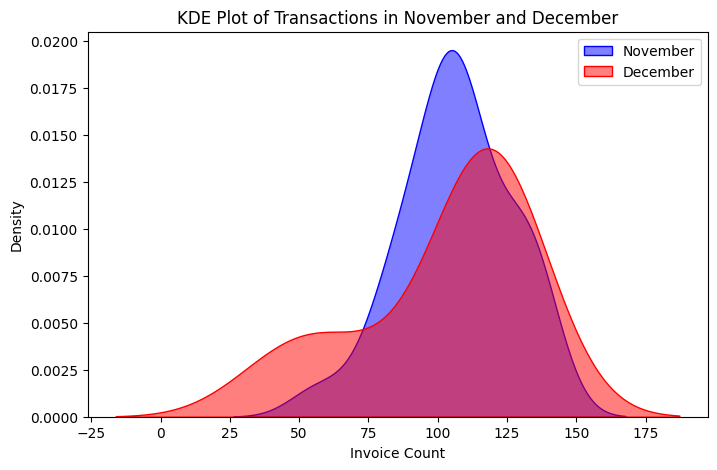

In [34]:
# let's look at kde plots

plt.figure(figsize=(8, 5))

sns.kdeplot(nov_trx, label="November", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec_trx, label="December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of Transactions in November and December")

plt.legend()

plt.savefig("kde.png")
plt.show()

The KDE plot **visually confirms** what the standard deviation hinted at—December's transaction values are much more **spread out**, while November's are **tightly concentrated**.  

**Why Does This Solidify Our Concern About the Mean?**  
- The **mean assumes a balanced, symmetrical distribution** where most values are close to the center.  
- But in December, we see **wide fluctuations**, meaning the mean could be **misleading** because:  
  - Some days had **very low transactions (~50)**, dragging the mean down.  
  - Some days had **high transactions (~120-130)**, pushing the mean up.  
  - This mix of low and high values makes the mean unstable.  

So, yes—this KDE plot **justifies why the mean isn’t a good representative!**

**Now, How Can Welch’s t-test Help?**  
Since we know the mean is shaky, Welch’s t-test will **mathematically quantify how unreliable** the mean difference is.  

**What it does:**  
- It tests **whether the difference in means is statistically significant** or if it's just random fluctuation.  
- It accounts for **unequal variances and different sample sizes** (which we have).  
- If the **p-value > 0.05**, the difference in means **isn’t significant**, proving our point that the mean is unreliable!  

In [35]:
from scipy.stats import ttest_ind

# Perform Welch's t-test (equal_var=False accounts for different variances)
t_stat, p_value = ttest_ind(nov_trx, dec_trx, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("🔴 The difference in means is statistically significant. (Reject H0)")
else:
    print("🟢 The difference in means is NOT statistically significant. (Fail to reject H0)")

T-statistic: 0.3610
P-value: 0.7265
🟢 The difference in means is NOT statistically significant. (Fail to reject H0)


**Does This Mean Our Initial Assumption About the Mean Was Wrong?**  

**No, our assumption is still correct!**  
The Welch’s t-test **does not test whether the mean is a good representative**. Instead, it **tests whether the two means are significantly different** from each other.  

**What Does This Test Actually Do?**  
- **Null Hypothesis (H₀)**: The means of November and December are the **same**.  
- **Alternative Hypothesis (H₁)**: The means of November and December are **different**.  

Your **p-value = 0.7265**, which is very high (>0.05). This means:  
✅ The test **found no significant difference** between the two means.  
✅ It suggests that the small difference in means **could just be random chance**.  

**Does This Mean the Mean is Reliable?**  

**No, because the test doesn’t measure that!** The test only tells us that the means aren’t significantly different.  

We still know:  
1. **December has higher variability (std = 30.42 vs. 19.66)**.  
2. **December’s data is more spread out (confirmed by KDE plot)**.  
3. **Mean doesn’t represent December well** because of its inconsistent spread.  

So, while the means aren’t statistically different, **the high standard deviation still makes the mean unreliable as a summary statistic for December**.

**Final Takeaway 🚀**  

- **Welch’s t-test shows the two means are not significantly different.**  
- **But it does NOT mean the mean is a good representative!**  
- **Given high variability, median or another robust metric is still better.**  

In [39]:
# let's look at another representative for two groups

from scipy.stats import mannwhitneyu

median_nov = np.median(nov_trx)
median_dec = np.median(dec_trx)

print(f"Median (November): {median_nov}")
print(f"Median (December): {median_dec}")

q1_nov, q3_nov = np.percentile(nov_trx, [25, 75])
iqr_nov = q3_nov - q1_nov

q1_dec, q3_dec = np.percentile(dec_trx, [25, 75])
iqr_dec = q3_dec - q1_dec

print(f"IQR (November): {iqr_nov}")
print(f"IQR (December): {iqr_dec}")

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(nov_trx, dec_trx, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("🔴 The distributions are significantly different. (Reject H0)")
else:
    print("🟢 No significant difference in distributions. (Fail to reject H0)")


Median (November): 107.5
Median (December): 117.5
IQR (November): 22.5
IQR (December): 24.25
Mann-Whitney U statistic: 96.5
P-value: 0.7760243798118613
🟢 No significant difference in distributions. (Fail to reject H0)


**1️⃣ Median Comparison (More Reliable Than Mean)**

- **November Median = 107.5**  
- **December Median = 117.5**  
✅ **December’s median is higher**, suggesting that transactions **might** have increased.  
❌ **But the difference is small (only +10 invoices), so it’s not a strong increase.**  

**2️⃣ IQR (Variability of Transactions)**

- **November IQR = 22.5**  
- **December IQR = 24.25**  
✅ December has a **slightly wider spread**, but the difference is small.  
❌ This means **December’s transactions were not much more variable** than November’s.  

**3️⃣ Mann-Whitney U Test (Statistical Significance)**

- **U statistic = 96.5**  
- **P-value = 0.776** (way above 0.05)  
🟢 **Since p-value > 0.05, we fail to reject H₀ (no significant difference).**  
❌ This confirms that **the slight median difference is not statistically meaningful**—it could just be random variation.  

**🚀 Final Conclusion**
1. **December’s median is slightly higher (+10 invoices), but the difference is too small to be meaningful.**  
2. **The transaction variability (IQR) is almost the same, meaning fluctuation patterns were similar.**  
3. **The Mann-Whitney U test confirms that there is NO statistically significant difference.**  

**👉 Verdict:** There is **no strong evidence** that transactions increased in December compared to November. The slight median increase is **not enough** to conclude a meaningful rise.  

###### AOV (Average Order Value)

In [56]:
nov_aov = november_data.groupby('InvoiceNo')[["Quantity", "UnitPrice"]].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())
dec_aov = december_data.groupby('InvoiceNo')[["Quantity", "UnitPrice"]].apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum())

In [63]:
print(f"November Mean: {nov_aov.mean()} and Std: {nov_aov.std()}")
print(f"December Mean: {dec_aov.mean()} and Std: {dec_aov.std()}")

November Mean: 545.1413253882268 and Std: 1654.4874520313547
December Mean: 779.9666422466424 and Std: 5992.582128615431


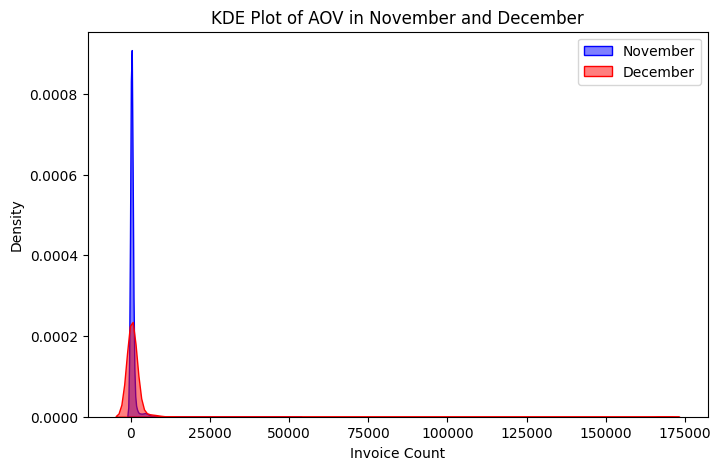

In [62]:
# looking at kdeplot

plt.figure(figsize=(8, 5))

sns.kdeplot(nov_aov, label="November", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec_aov, label="December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of AOV in November and December")

plt.legend()

plt.savefig("kde.png")
plt.show()

The standard deviation (std) is huge for both months, but December’s is much larger (5992 vs. 1654).  
BUT the KDE plot doesn’t show that extreme spread, meaning a few extreme outliers are inflating the standard deviation.

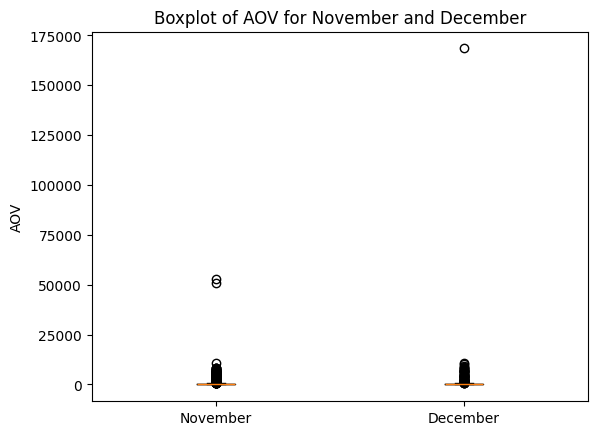

November 95th percentile: 1507.5099999999986
December 95th percentile: 1852.895
Number of rows having value more than 95 percentile 41


In [74]:
# let's check if there are extremes values in december that's why it's std is high

# Boxplot to visualize outliers
plt.boxplot([nov_aov, dec_aov], tick_labels=['November', 'December'])
plt.title("Boxplot of AOV for November and December")
plt.ylabel("AOV")
plt.show()

# Check top 5% values
print("November 95th percentile:", np.percentile(nov_aov, 95))
print("December 95th percentile:", np.percentile(dec_aov, 95))

# looking at how many this values
print("Number of rows having value more than 95 percentile", dec_aov[dec_aov >= np.percentile(dec_aov, 95)].size)

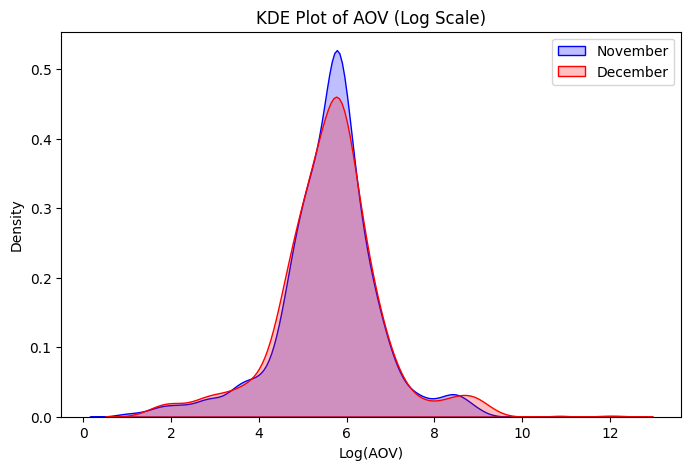

In [76]:
# so yeah that outlier is streching the value and thus it is also affecting the value of mean
# to see the difference very well let's use log scale and plot kde plot

plt.figure(figsize=(8,5))
sns.kdeplot(np.log1p(nov_aov), color='blue', label='November', fill=True)
sns.kdeplot(np.log1p(dec_aov), color='red', label='December', fill=True)
plt.xlabel("Log(AOV)")
plt.title("KDE Plot of AOV (Log Scale)")
plt.legend()
plt.show()

**What Log Scale Does in KDE:**

- **Brings extreme values closer to the main peaks**, so they don’t distort the overall shape.  
- **Preserves the overall structure** of the data while preventing a few large values from dominating the visualization.  
- **Makes the peaks (main transaction values) more visible**, instead of being overshadowed by outliers.  
- **Keeps outliers separate**, so you can still see that they exist without them ruining the scale.  

Now, instead of looking at a **skewed KDE where most values seem squished**, you get a **balanced view** of how AOV is actually distributed!

Looking at above KDE, there AOV value are about same. Let's look at median value of both group

In [78]:
# yeah meadian value is about the same. So there is no change in AOV value

median_nov = np.median(nov_aov)
median_dec = np.median(dec_aov)

print(f"Median (November): {median_nov}")
print(f"Median (December): {median_dec}")

Median (November): 300.6
Median (December): 300.54


Since AOV and transaction values are about same, this means that revenue should not increase

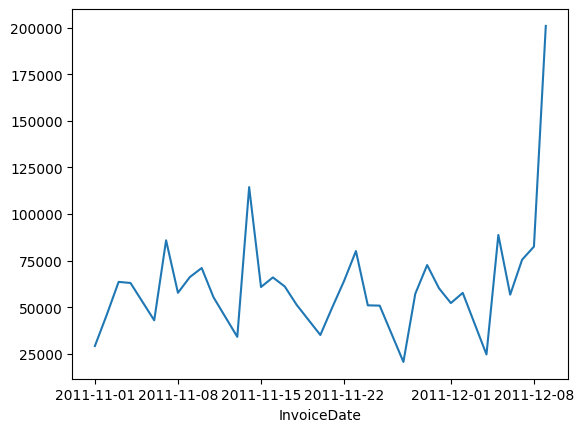

In [128]:
k = real_sales[real_sales["InvoiceDate"].dt.to_period("M") >= pd.Period("2011-11", "M")].copy(deep=True)
k["TotalPrice"] = k["Quantity"] * k["UnitPrice"]
k.groupby(k["InvoiceDate"].dt.date)["TotalPrice"].sum().plot()
plt.show()

###### Understanding why 9th december 2011 has highest recorded revenue

In [131]:
k.groupby(k["InvoiceDate"].dt.date)["TotalPrice"].sum().iloc[-2:]

InvoiceDate
2011-12-08     82495.0
2011-12-09    200920.6
Name: TotalPrice, dtype: float64

In [108]:
dec8 = k[k["InvoiceDate"].dt.date == pd.to_datetime("2011-12-08").date()]
dec9 = k[k["InvoiceDate"].dt.date == pd.to_datetime("2011-12-09").date()]

In [114]:
# comparing transaction values

print(f"December 8th transaction amt: {dec8['InvoiceNo'].nunique()}")
print(f"December 9th transaction amt: {dec9['InvoiceNo'].nunique()}")

December 8th transaction amt: 120
December 9th transaction amt: 44


***These are not AOV but order per invoice***

In [116]:
# comparing AOV values

dec8aov = dec8.groupby("InvoiceNo")["TotalPrice"].sum()
dec9aov = dec9.groupby("InvoiceNo")["TotalPrice"].sum()

print(f"8th Mean: {dec8aov.mean()} and Std: {dec8aov.std()}")
print(f"9th Mean: {dec9aov.mean()} and Std: {dec9aov.std()}")

8th Mean: 687.4583333333334 and Std: 1574.650664621254
9th Mean: 4566.3772727272735 and Std: 25325.727252581062


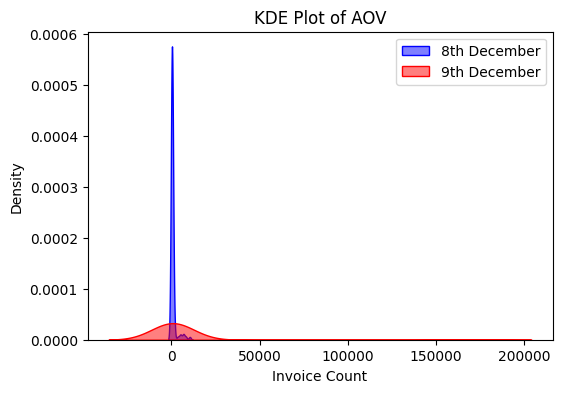

In [136]:
# looking at kdeplot

plt.figure(figsize=(6, 4))

sns.kdeplot(dec8aov.values, label="8th December", fill=True, color='blue', alpha=0.5)
sns.kdeplot(dec9aov.values, label="9th December", fill=True, color='red', alpha=0.5)

plt.xlabel("Invoice Count")
plt.ylabel("Density")
plt.title("KDE Plot of AOV")

plt.legend()
plt.show()

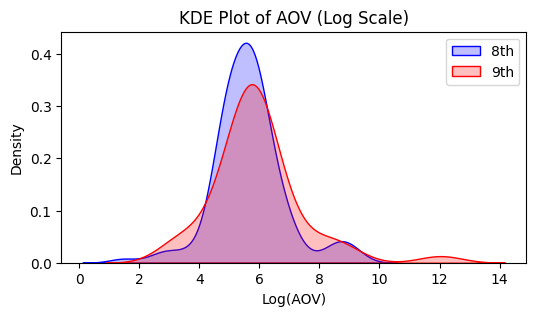

In [133]:
plt.figure(figsize=(6,3))
sns.kdeplot(np.log1p(dec8aov), color='blue', label='8th', fill=True)
sns.kdeplot(np.log1p(dec9aov), color='red', label='9th', fill=True)
plt.xlabel("Log(AOV)")
plt.title("KDE Plot of AOV (Log Scale)")
plt.legend()
plt.savefig("kde.png")
plt.show()

Since transaction is not higher in 9th december so i thought that due to high AOV, the revenue is highest.
But looking at above log scale KDE, the majority orders have same order per invoice (not aov as we didn't calculate mean).
Note that KDE plot show the peaks as those values having repeated more times. So majority of transaction in both 
the date have similar AOV, so similar revenue.

Thus it leads to think that, due to outlier order per invoice in 9th december. The revenue becomes the highest.

In [138]:
np.percentile(dec8aov, 95), np.percentile(dec9aov, 95)

(np.float64(3661.4009999999967), np.float64(5297.736500000003))

In [143]:
# so invoice No 581483 is having huge outlier

dec9aov[dec9aov >= np.percentile(dec9aov, 80)]

InvoiceNo
581476      2618.89
581483    168469.60
581485       741.90
581492      7689.23
581495      1203.90
581497      3217.20
581498      5664.89
581578       848.55
581579       903.62
Name: TotalPrice, dtype: float64

In [150]:
m = dec9aov.sum() - dec9aov[581483]
print(f"Original Revenue: {dec9aov.sum()}")
print(f"Subtracted Revenue: {m}")
print(f"Percentage Dropped Revenue: {(1 - (m / dec9aov.sum())) * 100}")

Original Revenue: 200920.60000000003
Subtracted Revenue: 32451.00000000003
Percentage Dropped Revenue: 83.84884377211694


- 83.85% of the revenue on December 9th came from just one extreme transaction.
- Without that one high-value order, revenue drops from 200,920 to just 32,451.
- This means the overall business activity (transactions & typical order values) was NOT drastically different—it was just one huge order inflating the numbers.

In [151]:
# looking at the invoice

k[k["InvoiceNo"] == 581483]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,YearMonth,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12,168469.6


Let's look at revenue per day from lens of median

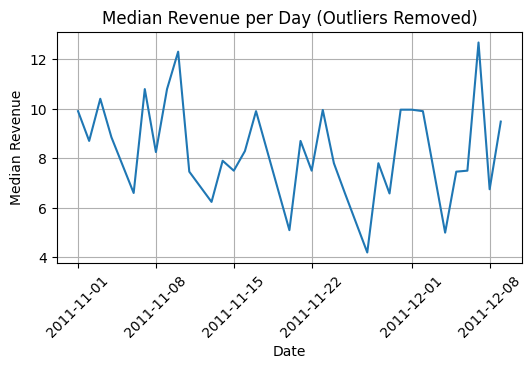

In [159]:
real_sales["TotalPrice"] = real_sales["Quantity"] * real_sales["UnitPrice"]
daily_median_revenue = real_sales[real_sales["InvoiceDate"].dt.date >= pd.to_datetime("2011-11-01").date()].groupby(df['InvoiceDate'].dt.date)['TotalPrice'].median()

plt.figure(figsize=(6,3))
plt.plot(daily_median_revenue.index, daily_median_revenue.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Median Revenue")
plt.title("Median Revenue per Day (Outliers Removed)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.show()